# Importação de bibliotecas necessárias

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from wordcloud import WordCloud, STOPWORDS
import joblib

## Carregamento dos Dados

In [11]:
df = pd.read_csv('teste_indicium_precificacao.csv')

## Informações Gerais

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

## Estatísticas Descritivas

In [13]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


# Análise Exploratória de Dados (EDA)

 ## Tratamento de Dados

In [14]:
df.fillna({'reviews_por_mes': 0, 'ultima_review': 'No Review'}, inplace=True)

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]


## Primeiras linhas do dataset

In [15]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,No Review,0.00,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# Distribuição dos preços

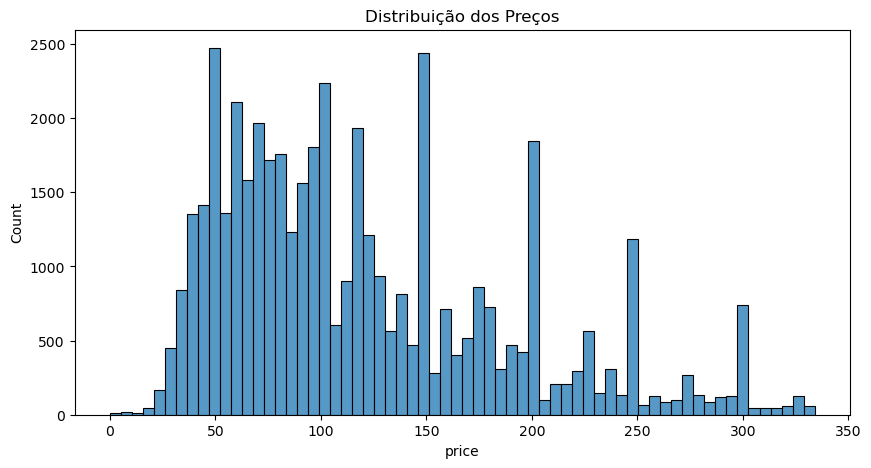

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df['price'])
plt.title('Distribuição dos Preços')
plt.show()

# Média de Preço por Tipo de Acomodação

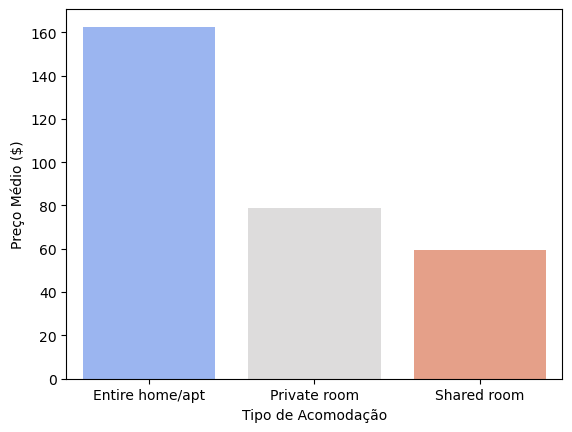

In [17]:
media_preco_room_type = df.groupby("room_type")["price"].mean().sort_values(ascending=False)

sns.barplot(x=media_preco_room_type.index, y=media_preco_room_type.values, palette="coolwarm")

plt.xlabel("Tipo de Acomodação")
plt.ylabel("Preço Médio ($)")
plt.show()

# Média de Preço por Tipo de Quarto ao Longo dos Anos

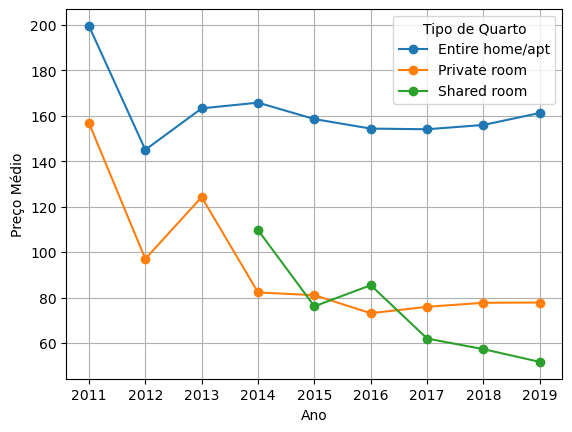

In [18]:
df_filtered = df[df['ultima_review'] != 'No Review'].copy()

df_filtered['ultima_review'] = pd.to_datetime(df_filtered['ultima_review'])

df_filtered['year'] = df_filtered['ultima_review'].dt.year

mean_price_by_room_type = df_filtered.groupby(['year', 'room_type'])['price'].mean().unstack()

mean_price_by_room_type.plot(kind='line', marker='o')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')
plt.legend(title='Tipo de Quarto')
plt.grid()
plt.show()

# Mapa de Correlação

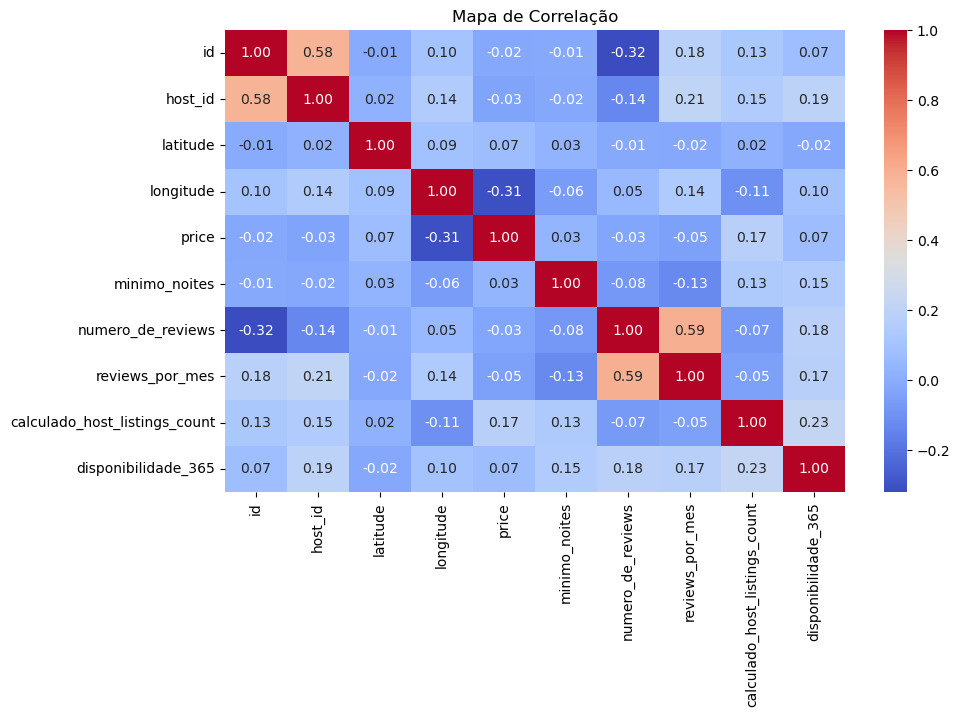

In [19]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Mapa de Correlação')
plt.show()

### Descrição do Mapa de Correlação

O mapa de correlação apresentado revela que as variáveis do conjunto de dados não exibem correlações significativas entre si. 


- **Correlação Fraca**: A maioria das variáveis apresenta coeficientes de correlação próximos de zero, indicando uma ausência de relação linear forte. Isso sugere que as variáveis não se influenciam diretamente ou que suas interações são complexas e não lineares.
- **Variáveis Categóricas**: Embora algumas variáveis categóricas, como bairro e tipo de quarto, possam afetar o preço, o mapa de correlação não capta essas relações, já que o coeficiente de correlação de Pearson é mais adequado para variáveis numéricas.


# Análise de bairro para investimento

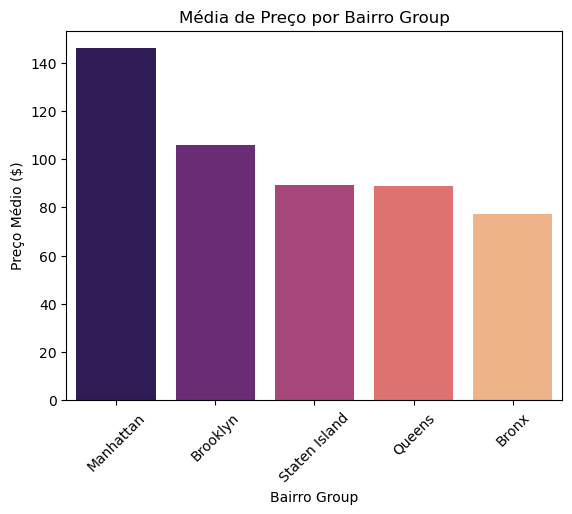

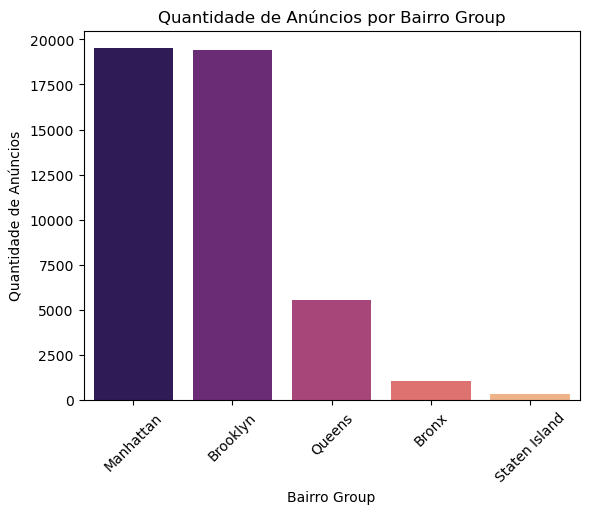

In [20]:
preco_medio_bairro_group = df.groupby("bairro_group")["price"].mean().sort_values(ascending=False)

sns.barplot(x=preco_medio_bairro_group.index, y=preco_medio_bairro_group.values, palette="magma")

plt.xticks(rotation=45)
plt.title("Média de Preço por Bairro Group")
plt.xlabel("Bairro Group")
plt.ylabel("Preço Médio ($)")
plt.show()

quantidade_anuncios_bairro_group = df["bairro_group"].value_counts()

sns.barplot(x=quantidade_anuncios_bairro_group.index, y=quantidade_anuncios_bairro_group.values, palette="magma")

plt.xticks(rotation=45)
plt.title("Quantidade de Anúncios por Bairro Group")
plt.xlabel("Bairro Group")
plt.ylabel("Quantidade de Anúncios")
plt.show()


### Onde seria mais indicada a compra?

Com base na análise dos gráficos, a compra de um apartamento para alugar na plataforma deve ser direcionada para regiões com alta valorização e demanda robusta. 

**Média de Preço por Bairro**:
   - **Recomendação**: Investir em áreas como **Manhattan**, onde os preços são significativamente mais altos, pode ser uma boa opção. A valorização dessa área indica que há locatários dispostos a pagar mais, resultando em um potencial retorno sobre o investimento mais elevado.

### Conclusão
A análise sugere que **Manhattan** é uma região ideal para investimento, devido à sua alta demanda e preços elevados. No entanto, considerar **Brooklyn** e **Queens** também pode ser interessante, especialmente se houver estratégias competitivas em mente para se destacar na oferta.

Essa combinação de fatores deve ser considerada ao tomar decisões de investimento para maximizar retornos na plataforma.

# Análise de Noites Mínimas e Disponibilidade

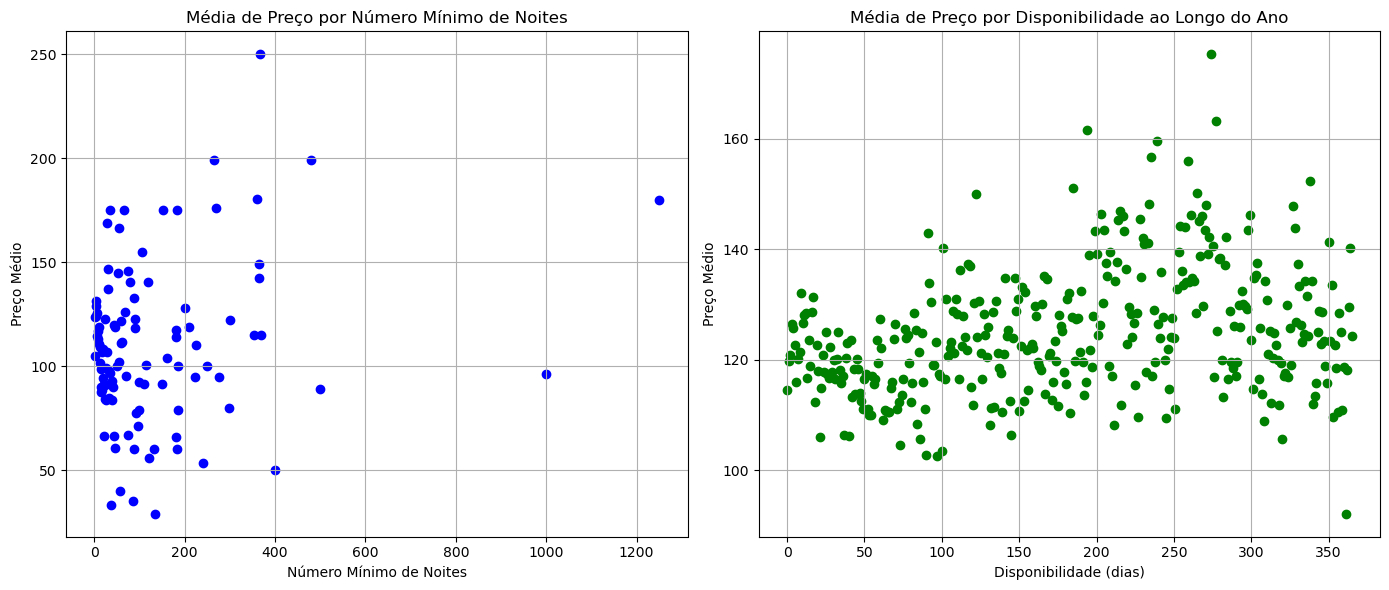

In [21]:
mean_price_by_min_nights = df.groupby('minimo_noites')['price'].mean()

mean_price_by_availability = df.groupby('disponibilidade_365')['price'].mean()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(mean_price_by_min_nights.index, mean_price_by_min_nights.values, color='blue')
plt.title('Média de Preço por Número Mínimo de Noites')
plt.xlabel('Número Mínimo de Noites')
plt.ylabel('Preço Médio')
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(mean_price_by_availability.index, mean_price_by_availability.values, color='green')
plt.title('Média de Preço por Disponibilidade ao Longo do Ano')
plt.xlabel('Disponibilidade (dias)')
plt.ylabel('Preço Médio')
plt.grid()

plt.tight_layout()
plt.show()

## Conclusão
A análise das noites mínimas e da disponibilidade revela que ambos os fatores influenciam diretamente o preço e a taxa de ocupação. Ajustes nessas variáveis são essenciais para otimizar o desempenho das propriedades na plataforma.

# Análise das Palavras Comuns em Anúncios Caros


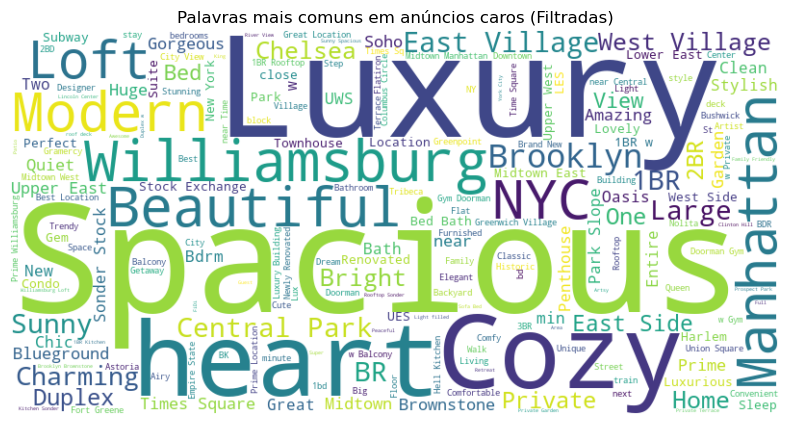

In [22]:
stopwords_personalizadas = set(STOPWORDS)
stopwords_personalizadas.update(["apartment", "apt", "bedroom", "studio", "room", "place", "house"])

top_20_percent = df[df['price'] > df['price'].quantile(0.80)]

text = " ".join(top_20_percent['nome'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white",
                      stopwords=stopwords_personalizadas).generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Palavras mais comuns em anúncios caros (Filtradas)")
plt.show()

### Palavras mais Comuns
- Anúncios de alta faixa de preço frequentemente incluem certas palavras-chave que destacam características desejáveis.
- Termos como **"luxury"**, **"cozy"**, **"modern"**, e **"spacious"** indicam que propriedades de maior valor tendem a realçar características de conforto e exclusividade.
- Incorporar essas palavras nos anúncios pode aumentar a percepção de valor das propriedades e atrair uma clientela disposta a pagar mais.

# Modelagem

In [31]:
features = df[['bairro_group', 'room_type', 'disponibilidade_365', 'minimo_noites', 
               'numero_de_reviews', 'reviews_por_mes', 'latitude', 'longitude']]
target = df['price']

features = pd.get_dummies(features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

RMSE: 45.53
R²: 0.5531


## Descrição do Modelo de Previsão de Preço

### Objetivo
Prever o preço de aluguel de propriedades utilizando um modelo de regressão.

### Variáveis Utilizadas
- **bairro_group**: Localização.
- **room_type**: Tipo de quarto disponível.
- **disponibilidade_365**: Dias disponíveis para aluguel.
- **minimo_noites**: Número mínimo de noites exigido.
- **numero_de_reviews**: Número total de avaliações.
- **reviews_por_mes**: Média de avaliações mensais.
- **latitude** e **longitude**: Coordenadas geográficas.

### Transformações
As variáveis categóricas foram convertidas em variáveis numéricas usando one-hot encoding, permitindo que o modelo as utilizasse adequadamente.

### Tipo de Problema
Estamos lidando com um problema de regressão, já que o objetivo é prever um valor contínuo (preço do aluguel).

### Modelo Utilizado
O modelo escolhido foi o Random Forest Regressor:
- Prós: Robustez a outliers, capacidade de capturar interações complexas.
- Contras: Difícil interpretação e maior tempo de treinamento.

### Medidas de Performance
As métricas de avaliação foram:
- RMSE: Indica o erro médio das previsões.
- R²: Mede a proporção da variabilidade explicada pelo modelo.

# Sugestão de preço para um apartamento específico

In [33]:
apto = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

apto_df = pd.DataFrame([apto])

apto_df = apto_df.drop(columns=['id', 'nome', 'host_id', 'host_name', 'bairro', 'ultima_review'])

apto_df = pd.get_dummies(apto_df, columns=['room_type', 'bairro_group'], drop_first=True)

for col in X_train.columns:
    if col not in apto_df.columns:
        apto_df[col] = 0

apto_df = apto_df[X_train.columns]

preco_previsto = model.predict(apto_df)

print(f"Preço previsto para o apartamento: ${preco_previsto[0]:.2f}")


Preço previsto para o apartamento: $204.94


## Salvando o Modelo

In [34]:
joblib.dump(model, 'modelo_precos.pkl')

['modelo_precos.pkl']